Loading data from Spark output folder: s3://processed-data/bahrain_stint_analysis.parquet...

Processed data loaded successfully:
  Driver  Stint  AvgLapTime  MinLapTime  MaxLapTime  LapsInStint
0    ALB    1.0   99.109357      98.422     103.888           14
1    ALB    2.0   97.956105      97.392      98.346           19
2    ALB    3.0   96.287053      95.723      97.616           19
3    ALO    1.0   98.749571      97.776     101.679           14
4    ALO    2.0   97.298917      96.799      98.343           24

Generating plot...


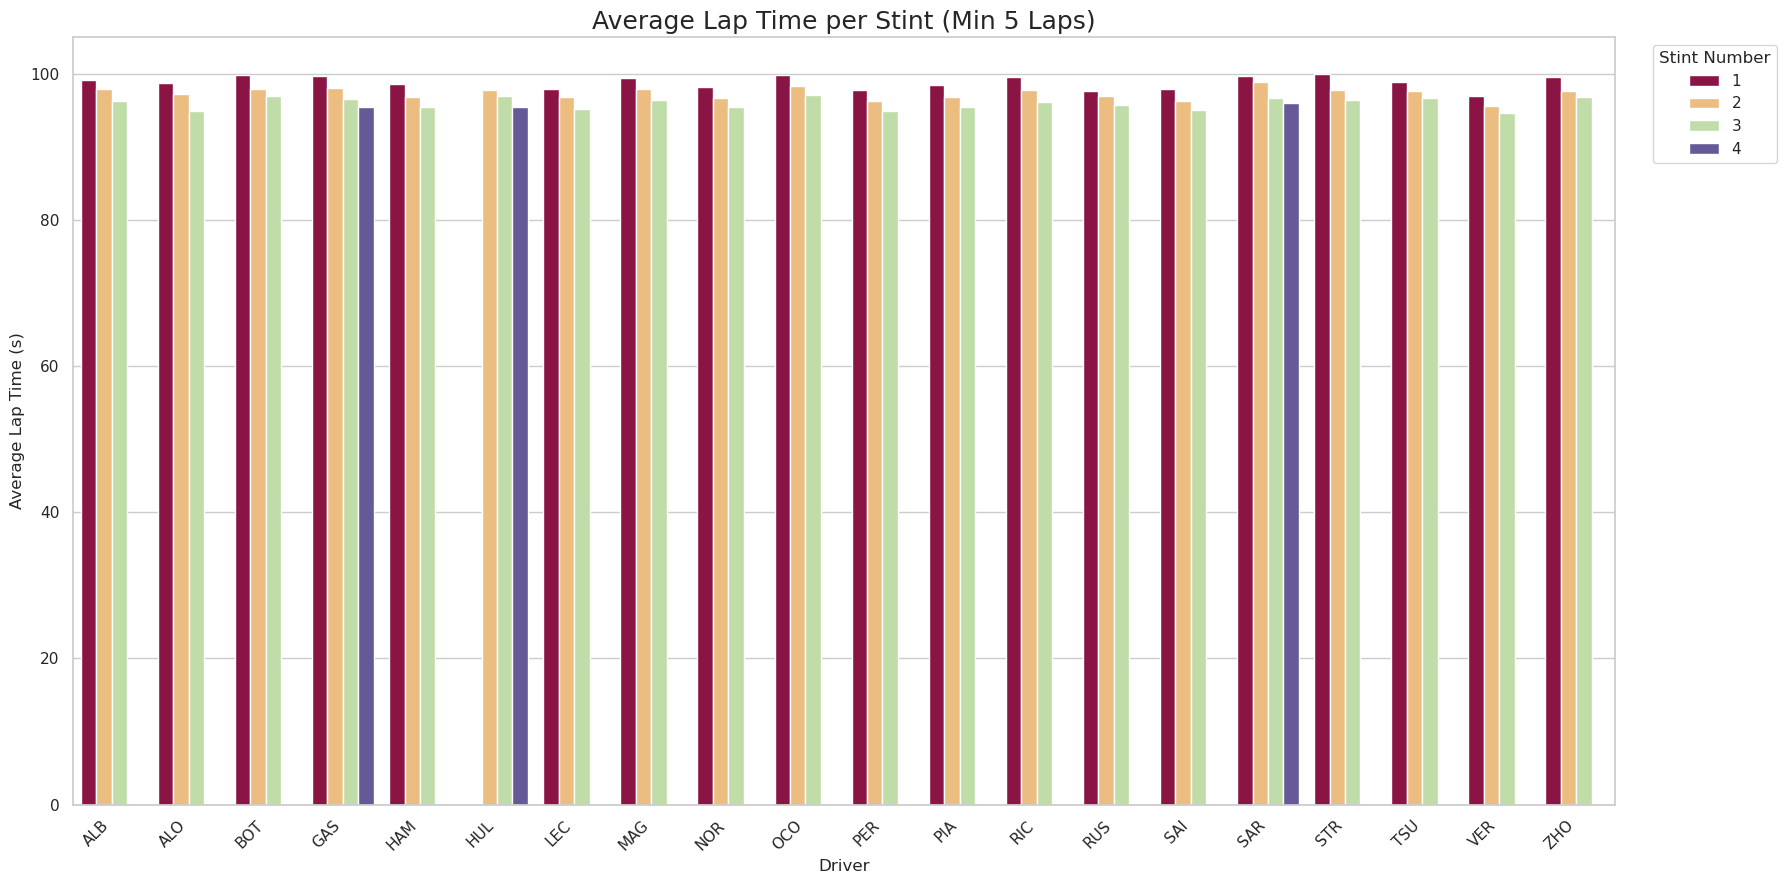

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import s3fs # We still need this for pandas to talk to s3

# --- 1. Configure S3 (MinIO) Connection ---
# We create a dictionary of our S3 credentials
# Pandas will use this to connect to MinIO
storage_options = {
    "key": "minioadmin",
    "secret": "minioadmin",
    "client_kwargs": {"endpoint_url": "http://minio:9000"}
}

# --- 2. Read Processed Data from Spark Folder ---
# This path IS A FOLDER, which is correct for Spark output
folder_path = 's3://processed-data/bahrain_stint_analysis.parquet'

try:
    print(f"Loading data from Spark output folder: {folder_path}...")
    
    # --- THIS IS THE FIX ---
    # We tell pandas to read the FOLDER, passing our S3 config.
    # Pandas is smart enough to find the "part-..." files inside.
    df = pd.read_parquet(
        folder_path,
        storage_options=storage_options
    )
    # --- END FIX ---

    print("\nProcessed data loaded successfully:")
    print(df.head())

except Exception as e:
    print(f"Error: Could not read data from {folder_path}")
    print(f"Details: {e}")


# --- 3. Plot the Tire Degradation Analysis ---
# (The rest of this script is the same as before)
print("\nGenerating plot...")

# Filter for stints that are long enough to be meaningful (e.g., > 5 laps)
# Use .copy() to avoid a pandas warning
plot_df = df.query("LapsInStint > 5").copy()

# Convert Stint to an integer for cleaner plot labels
if not plot_df.empty:
    plot_df['Stint'] = plot_df['Stint'].astype(int)

    # Set the theme and figure size
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(18, 9)) # Made the plot wider

    # Create the bar plot
    ax = sns.barplot(
        data=plot_df,
        x="Driver",
        y="AvgLapTime",
        hue="Stint",  # Group bars by stint number
        palette="Spectral" # Use a color palette that shows change
    )
    
    ax.set_title(f"Average Lap Time per Stint (Min 5 Laps)", fontsize=18)
    ax.set_ylabel("Average Lap Time (s)", fontsize=12)
    ax.set_xlabel("Driver", fontsize=12)
    
    # Improve layout
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Stint Number', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout() # Adjusts plot to prevent labels from overlapping
    
    # Show the plot
    plt.show()
else:
    print("No data to plot after filtering (LapsInStint > 5).")